In this notebook I want to explore, given 2 2D polyhedrons, how can I find out what all the possible contact modes there are between them and the corresponding contact locations, constraints, whether contact or no contact

In [1]:
from large_gcs.contact.contact_pair_mode import generate_contact_pair_modes
from large_gcs.contact.rigid_body import RigidBody, MobilityType
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt


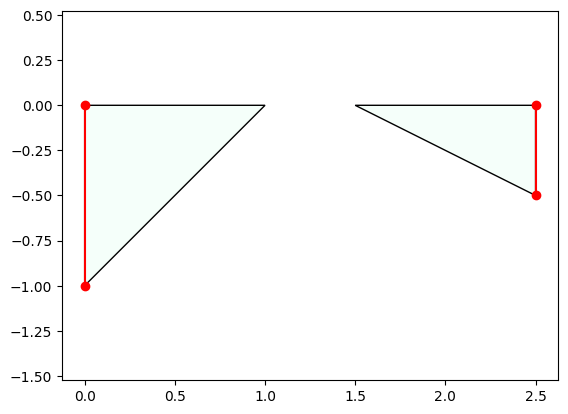

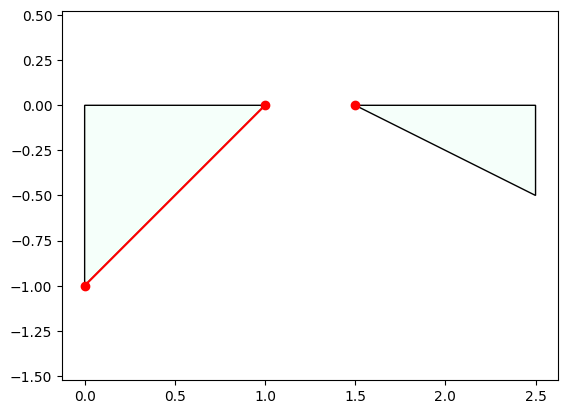

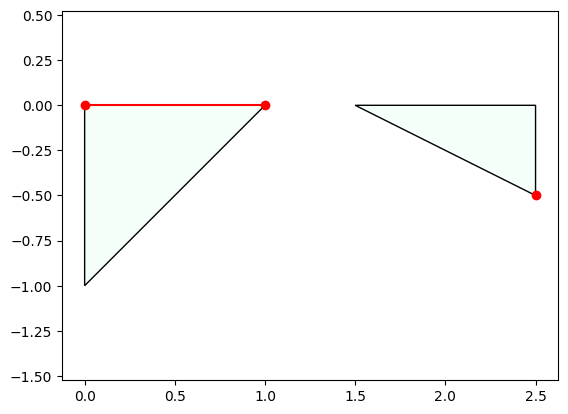

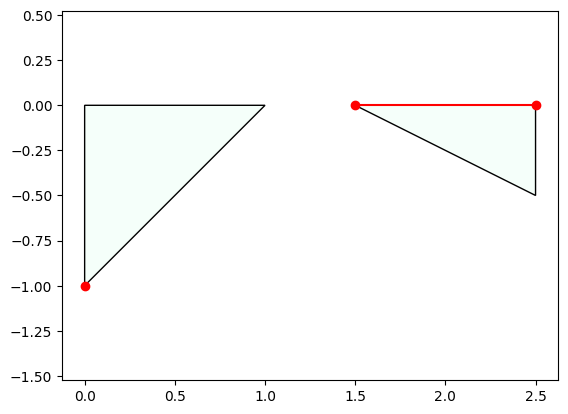

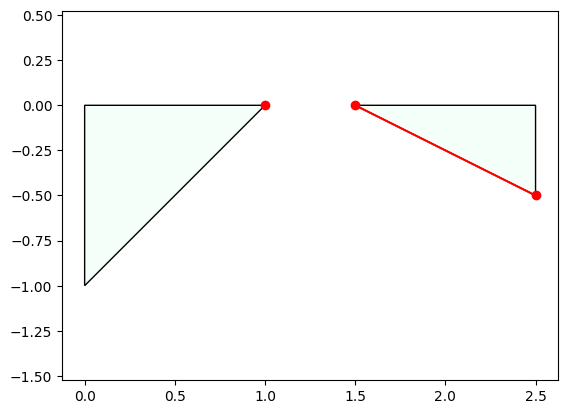

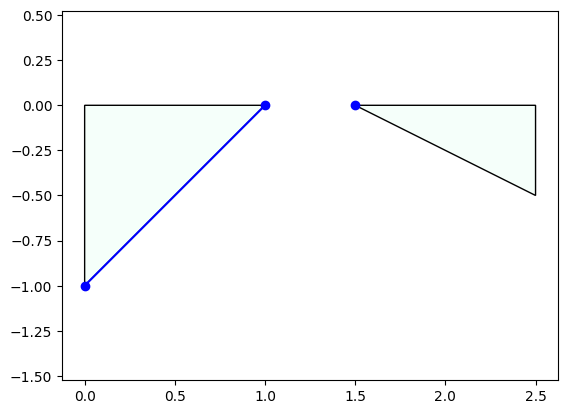

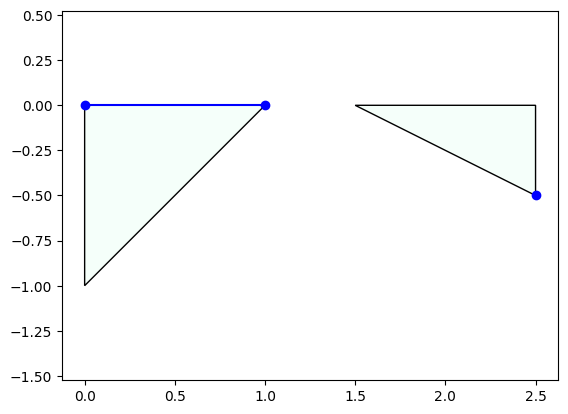

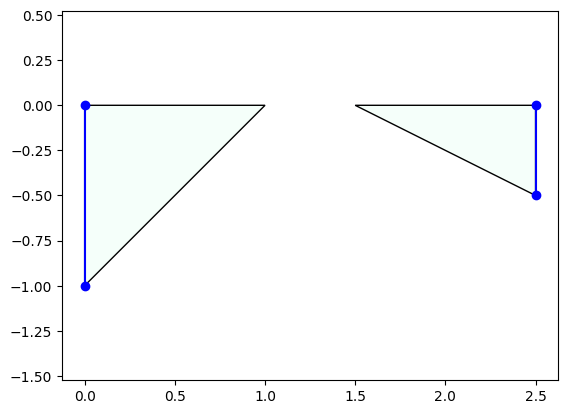

In [2]:
obj_vertices = np.array([[0, 0], [1, 0], [1, -0.5]]) + np.array([1.5,0])
# obj_vertices = np.array([[0, 0], [1, 0.2], [0.7, -0.5]]) + np.array([1.5,0])
# obj_vertices = np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([1.5,0])
obs = RigidBody(name="obstacle", geometry=Polyhedron.from_vertices([[0, 0], [1, 0], [0, -1]]), mobility_type=MobilityType.STATIC)
obj = RigidBody(name="object", geometry=Polyhedron.from_vertices(obj_vertices), mobility_type=MobilityType.ACTUATED)
# obs.geometry.plot()
# obj.geometry.plot()


contact_pair_modes = generate_contact_pair_modes(obs, obj)
for contact_pair_mode in contact_pair_modes:
    contact_pair_mode.plot()



In [3]:
len(contact_pair_modes)

8

Testing individual functionality

In [4]:
obj = RigidBody(name="object", geometry=Polyhedron.from_vertices([[0, 0], [1, 0], [1, -0.5]]), mobility_type=MobilityType.ACTUATED)
# obj.geometry.plot(mark_center=True)
# print("vertices", obj.geometry.vertices)
# print("A", obj.geometry.set.A())
# print("b", obj.geometry.set.b())
# obj.geometry.plot_face(0, color="r")
# obj.geometry.plot_halfspace(2, color="blue", alpha=0.5, linestyle="-.")

# v = ContactLocationVertex(body=obj, index=2)
# v.plot()
# e = ContactLocationEdge(body=obj, halfspace_index=0)
# e.adj_vertex_indices